In [1]:
import sys, os
sys.path.append("../..")
sys.path.append("..")
sys.path.append(os.getcwd())
import re
import datetime

from matplotlib import pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.dates as mdates
import seaborn as sns
sns.set()
sns.set(palette="bright")
sns.set_style("whitegrid")

from sklearn import linear_model
from cycler import cycler
from celluloid import Camera

from IPython.display import HTML

import importlib

#importlib.reload(some_module)


import warnings

import numpy as np
import pandas as pd
import copy
import random


from tslib.src import tsUtils
from tslib.tests import testdata

#warnings.filterwarnings(action='once')

from sklearn.cluster import KMeans, AgglomerativeClustering, AffinityPropagation, DBSCAN #For clustering
from sklearn.mixture import GaussianMixture #For GMM clustering

import hdbscan


In [2]:
from filter_data import *

#global settings for graphs        
cc = (cycler(linestyle=['-', '--', '-.',':']) * cycler(color=list('brgcmyk')))
plt.rc('lines', linewidth=2)
plt.rc('axes', prop_cycle=cc)
plt.rcParams.update({'font.size': 14})
plt.rcParams['figure.figsize'] = (8.0, 6.0)

plt.rcParams["animation.html"] = "html5"

In [3]:
from load_and_clean import *

#update_data()

us = load_clean('NYTimes US')
uscases, usdeaths, usstates = load_clean('NYTimes states')
uscounties_cases, uscounties_deaths, uscounties = load_clean('NYTimes counties')
global_cases, global_deaths = load_clean('JHU global')
us_covid_jhu_cases, us_covid_jhu_deaths = load_clean('JHU US')
mobility_data_apple, mobility_data_google, google_social = load_clean('mobility')
sd_data = load_clean('IHME intervention')
all_population, us_population, usstates_population, uscounties_population = load_clean('population')

uscases_pop_adjusted, usdeaths_pop_adjusted = create_population_adjusted_data(uscases, all_population), \
                                    create_population_adjusted_data(usdeaths, all_population, show_exception = True)
global_cases_pop_adjusted, global_deaths_pop_adjusted = create_population_adjusted_data(global_cases, all_population), \
                                    create_population_adjusted_data(global_deaths, all_population, show_exception = True)

uscounties_cases_pop_adjusted = create_population_adjusted_data(uscounties_cases, all_population, show_exception = True, county = True)
uscounties_deaths_pop_adjusted = create_population_adjusted_data(uscounties_deaths, all_population, county = True)

state_reopen = load_clean('state reopen')
#fips_df = pd.read_csv("../COVID/COVID-19/csse_covid_19_data/UID_ISO_FIPS_LookUp_Table.csv")

These countries/region do not have population data ['Virgin Islands']
These countries/region do not have population data ['Bahamas', 'Cabo Verde', 'Congo (Brazzaville)', 'Congo (Kinshasa)', "Cote d'Ivoire", 'Diamond Princess', 'Eswatini', 'Gambia', 'Holy See', 'Kyrgyzstan', 'North Macedonia', 'Saint Lucia', 'Saint Vincent and the Grenadines', 'Slovakia', 'Taiwan*', 'Syria', 'West Bank and Gaza', 'Saint Kitts and Nevis', 'Burma', 'MS Zaandam', 'Western Sahara']
These countries/region do not have population data ['Adjuntas-Puerto Rico', 'Aguada-Puerto Rico', 'Aguadilla-Puerto Rico', 'Aguas Buenas-Puerto Rico', 'Aibonito-Puerto Rico', 'Anasco-Puerto Rico', 'Anchorage-Alaska', 'Arecibo-Puerto Rico', 'Arroyo-Puerto Rico', 'Barceloneta-Puerto Rico', 'Barranquitas-Puerto Rico', 'Bayamon-Puerto Rico', 'Cabo Rojo-Puerto Rico', 'Caguas-Puerto Rico', 'Camuy-Puerto Rico', 'Canovanas-Puerto Rico', 'Carolina-Puerto Rico', 'Catano-Puerto Rico', 'Cayey-Puerto Rico', 'Ceiba-Puerto Rico', 'Ciales-Puerto

In [51]:
#Filter data (this part might be overlapping some cells, but it should contain most of the varilables that are analyzed. )
# This part might be to split and explain
# This part might be to split and explain
t = 7
column = list(mobility_data_google.columns).index('retail_and_recreation_percent_change_from_baseline')
global_deaths_filtered = create_filtered_data(global_deaths, 500 )
#the last column of social distancing dataset is the last social distancing measure used by a location
educational_distancing = get_social_distancing(sd_data, sd_data.columns[-1])

all_data = pd.concat([global_deaths, usdeaths, uscounties_deaths], axis=1).dropna()
all_data_daily = create_rolling_data(all_data, t)

all_data_cases = pd.concat([global_cases, uscases, uscounties_cases], axis=1).dropna()
all_data_cases_daily = create_rolling_data(all_data_cases, t)

all_cases_data_pop = pd.concat([uscases_pop_adjusted,global_cases_pop_adjusted, uscounties_cases_pop_adjusted], axis = 1).dropna()
all_cases_data_pop_daily = create_rolling_data(all_cases_data_pop, t)

all_death_data_pop = pd.concat([usdeaths_pop_adjusted,global_deaths_pop_adjusted, uscounties_deaths_pop_adjusted], axis = 1).dropna()
all_death_data_pop_daily = create_rolling_data(all_death_data_pop, t)

_, daily_global, intervention_date_global = create_intervention_adjusted_data(global_deaths, educational_distancing, t)
_, daily_us, intervention_date_us = create_intervention_adjusted_data(usdeaths, educational_distancing, t)
_, daily_uscounties, intervention_date_uscounties = create_intervention_adjusted_data(uscounties_deaths, educational_distancing, t)

cases_intervention_adjusted, cases_intervention_adjusted_daily, intervention_date_case = create_intervention_adjusted_data(all_data_cases, educational_distancing, t)
deaths_intervention_adjusted, deaths_intervention_adjusted_daily, intervention_date_death = create_intervention_adjusted_data(all_data, educational_distancing, t)

all_cases_data_pop_adjusted, all_cases_data_pop_adjusted_daily, _ = create_intervention_adjusted_data(all_cases_data_pop, educational_distancing, t)
all_death_data_pop_adjusted, all_death_data_pop_adjusted_daily, _ = create_intervention_adjusted_data(all_death_data_pop, educational_distancing, t)


last date
Exceptions are []


In [12]:
masks_mandated = ['New York', 'Maine', 'Maryland', 'Virginia', 'New Mexico', 'California', 'Michigan', 'Illinois', 'Massachusetts','Delaware', 'Rhode Island']
masks_recommended = ['Montana', 'Idaho', 'Utah', 'Arizona', 'North Dakota', 'South Dakota', 'Kansas', 'Oklahoma', 
                     'Texas', 'North Carolina', 'South Carolina', 'West Virginia', 'Wisconsin','Iowa', 'Missouri', 'Alaska']
eu_countries = ['Austria', 'Belgium', 'Bulgaria', 'Croatia', 'Cyprus', 'Czechia', 'Denmark',
   'Estonia', 'Finland', 'France', 'Germany', 'Greece', 'Hungary', 'Ireland',
   'Italy', 'Latvia', 'Lithuania', 'Luxembourg', 'Malta', 'Netherlands',
   'Poland', 'Portugal', 'Romania', 'Slovenia', 'Spain', 'Sweden']

northeast = ["Connecticut","Maine","Massachusetts","New Hampshire",
             "Rhode Island","Vermont","New Jersey","New York",
             "Pennsylvania", "Delaware","District of Columbia","Maryland"]
midwest = ["Indiana","Illinois","Michigan","Ohio","Wisconsin",
             "Iowa","Kansas","Minnesota","Missouri","Nebraska",
             "North Dakota","South Dakota"]
south = ["Florida","Georgia",
            "North Carolina","South Carolina","Virginia",
            "West Virginia","Alabama","Kentucky","Mississippi",
            "Tennessee","Arkansas","Louisiana","Oklahoma","Texas"]

west= ["Arizona","Colorado","Idaho","New Mexico","Montana",
            "Utah","Nevada","Wyoming","Alaska","California",
            "Hawaii","Oregon","Washington"]

california_rollback = ["Fresno-California", "Imperial-California", "Kern-California", "Kings-California", "Los Angeles-California", "San Joaquin-California" , "Tulare-California",
                      "Riverside-California", "Sacramento-California", "San Bernardino-California", "Santa Barbara-California", "Santa Clara-California", "Contra Costa-California", "Stanislaus-California", 
                       "Ventura-California"]

google_counties = ['San Mateo-California', 'San Francisco-California', 'Santa Clara-California']

In [13]:
group_a = eu_countries
group_b = ['US']

group_a_label = "EU"
group_b_label = "US"


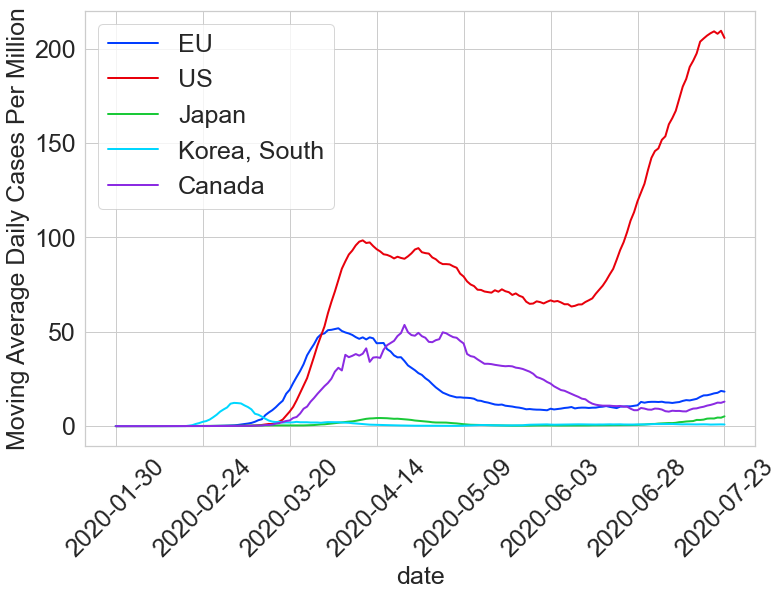

In [14]:
plt.rcParams['figure.figsize'] = (12, 8)
FONTSIZE = 25
dfplot = all_cases_data_pop_daily# all_data_cases_daily

dfplot[group_a].mean(axis=1).plot(label=group_a_label), dfplot[group_b].mean(axis=1).plot(label=group_b_label), 
dfplot['Japan'].plot(), dfplot['Korea, South'].plot(), dfplot['Canada'].plot(), plt.legend(),
plt.xticks(rotation=45,fontsize = FONTSIZE), plt.xlabel('date', fontsize = FONTSIZE), plt.ylabel('Moving Average Daily Cases Per Million',fontsize = FONTSIZE)#, plt.title('Cases')
plt.yticks(fontsize = FONTSIZE)
plt.legend(fontsize = FONTSIZE, loc='upper left')

#plt.savefig('../Figures/COVID/Global_cases.pdf', bbox_inches='tight')

In [15]:
groups = [northeast, west, south, midwest]
group_labels = ["North East", "West", "South", "Midwest"]
southwest = south+west

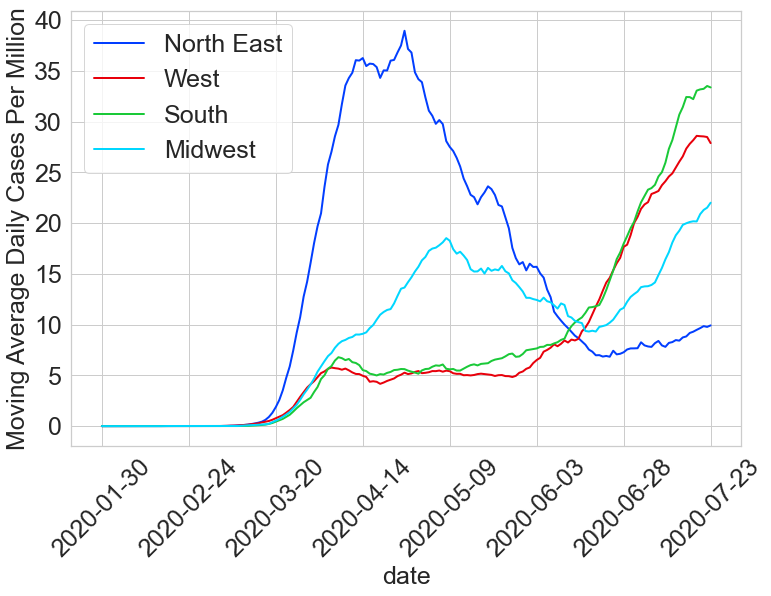

In [16]:
plt.rcParams['figure.figsize'] = (12, 8)
FONTSIZE = 25

dfplot=all_cases_data_pop_daily
i=0
for group in groups:
    (1000000*dfplot[group].sum(axis=1)/(all_population[all_population.index.isin(group)].value.sum())).plot(label=group_labels[i])
    plt.xticks(rotation=45, fontsize = FONTSIZE), plt.ylabel('Moving Average Daily Cases Per Million', fontsize = FONTSIZE), plt.xlabel('date' , fontsize = FONTSIZE)#, plt.title('Cases'),
    plt.yticks(fontsize = FONTSIZE)
    plt.legend(fontsize = FONTSIZE)
    i=i+1

#plt.savefig('../Figures/COVID/US_cases.pdf', bbox_inches='tight')


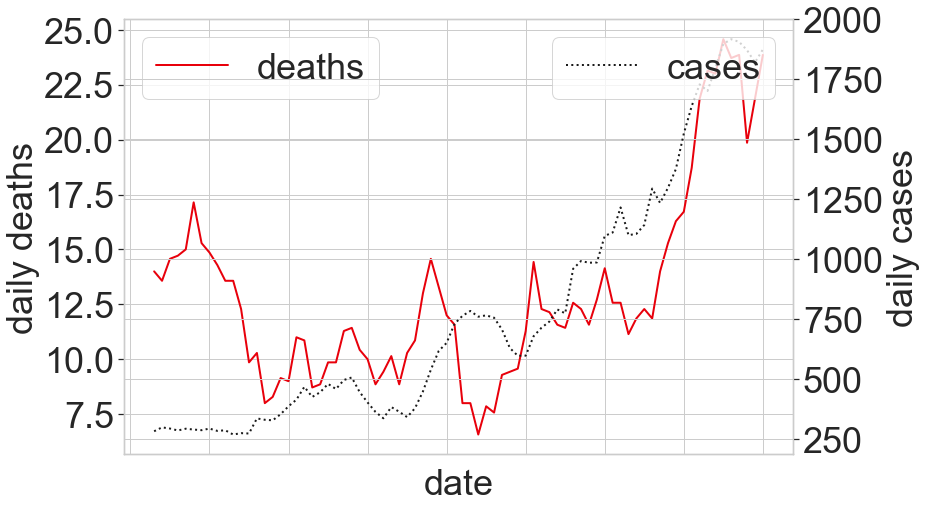

In [19]:
fig, ax = plt.subplots()

plt.rcParams['figure.figsize'] = (12.0, 8.0)


target ='Alabama'

FONTSIZE = 36

deaths_intervention_adjusted_daily[target].iloc[25:].plot(ax = ax, color='r', label='deaths')
#plt.legend()
plt.ylabel('daily deaths', fontsize = FONTSIZE ), plt.xlabel('date',fontsize = FONTSIZE)
plt.yticks(fontsize = FONTSIZE)
plt.legend(fontsize = FONTSIZE , loc = 'upper left')
#ax.set_xticks([])
ax.axes.xaxis.set_ticklabels([])


ax2 = ax.twinx()
ax2.set_ylabel('cases')
cases_intervention_adjusted_daily[target].iloc[25:].plot(ax = ax2, secondary_y=True, color='k',linestyle=":", label='cases')
#plt.legend()
plt.ylabel('daily cases', fontsize = FONTSIZE ), plt.xlabel('date',fontsize = FONTSIZE)

plt.legend(fontsize = FONTSIZE , loc = 'upper right')
plt.yticks(fontsize = FONTSIZE)
#ax2.set_xticks([])
ax2.axes.xaxis.set_ticklabels([])

#plt.savefig('../Figures/COVID/'+target+'_deaths_cases.pdf', bbox_inches='tight')

plt.show()

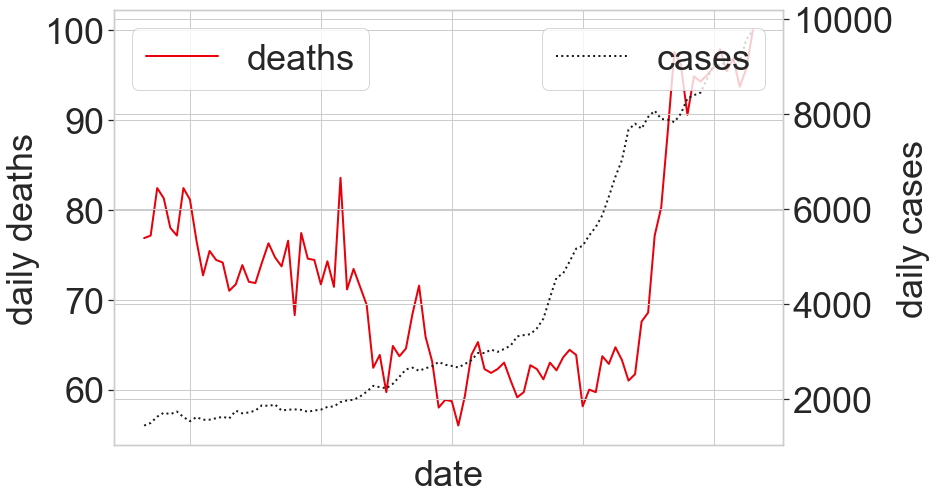

In [20]:
fig, ax = plt.subplots()

plt.rcParams['figure.figsize'] = (12.0, 8.0)


target ='California'

FONTSIZE = 36

deaths_intervention_adjusted_daily[target].iloc[25:].plot(ax = ax, color='r', label='deaths')
#plt.legend()
plt.ylabel('daily deaths', fontsize = FONTSIZE ), plt.xlabel('date',fontsize = FONTSIZE)
plt.yticks(fontsize = FONTSIZE)
plt.legend(fontsize = FONTSIZE , loc = 'upper left')
#ax.set_xticks([])
ax.axes.xaxis.set_ticklabels([])


ax2 = ax.twinx()
ax2.set_ylabel('cases')
cases_intervention_adjusted_daily[target].iloc[25:].plot(ax = ax2, secondary_y=True, color='k',linestyle=":", label='cases')
#plt.legend()
plt.ylabel('daily cases', fontsize = FONTSIZE ), plt.xlabel('date',fontsize = FONTSIZE)

plt.legend(fontsize = FONTSIZE , loc = 'upper right')
plt.yticks(fontsize = FONTSIZE)
#ax2.set_xticks([])
ax2.axes.xaxis.set_ticklabels([])

#plt.savefig('../Figures/COVID/'+target+'_deaths_cases.pdf', bbox_inches='tight')

plt.show()

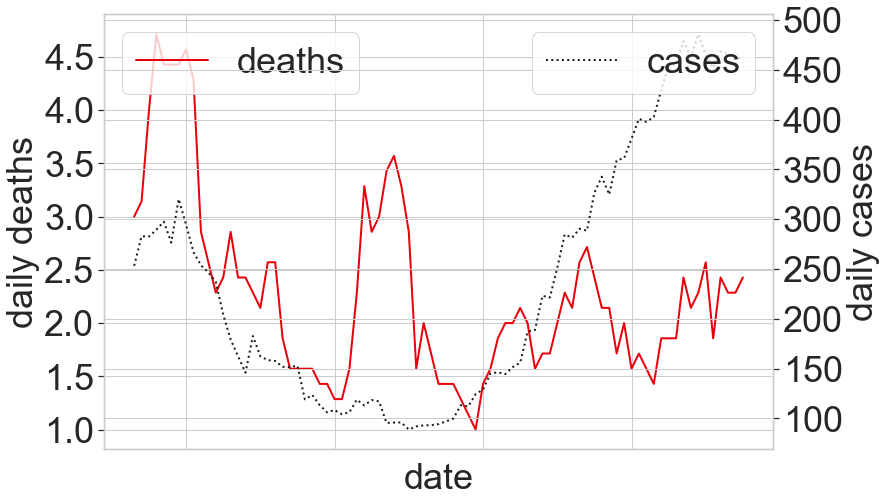

In [21]:
fig, ax = plt.subplots()

plt.rcParams['figure.figsize'] = (12.0, 8.0)


target ='Kansas'

FONTSIZE = 36

deaths_intervention_adjusted_daily[target].iloc[25:].plot(ax = ax, color='r', label='deaths')
#plt.legend()
plt.ylabel('daily deaths', fontsize = FONTSIZE ), plt.xlabel('date',fontsize = FONTSIZE)
plt.yticks(fontsize = FONTSIZE)
plt.legend(fontsize = FONTSIZE , loc = 'upper left')
#ax.set_xticks([])
ax.axes.xaxis.set_ticklabels([])


ax2 = ax.twinx()
ax2.set_ylabel('cases')
cases_intervention_adjusted_daily[target].iloc[25:].plot(ax = ax2, secondary_y=True, color='k',linestyle=":", label='cases')
#plt.legend()
plt.ylabel('daily cases', fontsize = FONTSIZE ), plt.xlabel('date',fontsize = FONTSIZE)

plt.legend(fontsize = FONTSIZE , loc = 'upper right')
plt.yticks(fontsize = FONTSIZE)
#ax2.set_xticks([])
ax2.axes.xaxis.set_ticklabels([])

#plt.savefig('../Figures/COVID/'+target+'_deaths_cases.pdf', bbox_inches='tight')

plt.show()

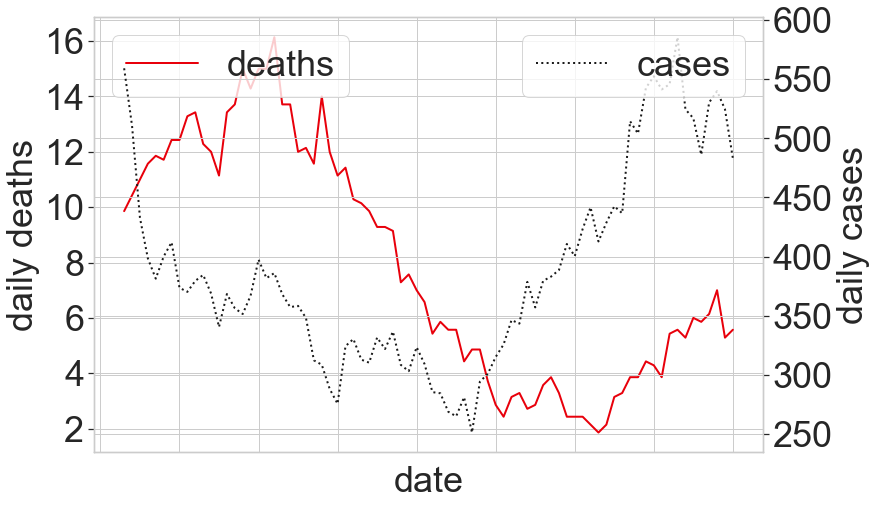

In [22]:
fig, ax = plt.subplots()

plt.rcParams['figure.figsize'] = (12.0, 8.0)


target ='Iowa'

FONTSIZE = 36

deaths_intervention_adjusted_daily[target].iloc[25:].plot(ax = ax, color='r', label='deaths')
#plt.legend()
plt.ylabel('daily deaths', fontsize = FONTSIZE ), plt.xlabel('date',fontsize = FONTSIZE)
plt.yticks(fontsize = FONTSIZE)
plt.legend(fontsize = FONTSIZE , loc = 'upper left')
#ax.set_xticks([])
ax.axes.xaxis.set_ticklabels([])


ax2 = ax.twinx()
ax2.set_ylabel('cases')
cases_intervention_adjusted_daily[target].iloc[25:].plot(ax = ax2, secondary_y=True, color='k',linestyle=":", label='cases')
#plt.legend()
plt.ylabel('daily cases', fontsize = FONTSIZE ), plt.xlabel('date',fontsize = FONTSIZE)

plt.legend(fontsize = FONTSIZE , loc = 'upper right')
plt.yticks(fontsize = FONTSIZE)
#ax2.set_xticks([])
ax2.axes.xaxis.set_ticklabels([])

#plt.savefig('../Figures/COVID/'+target+'_deaths_cases.pdf', bbox_inches='tight')

plt.show()

In [8]:
plt.rcParams['figure.figsize'] = (12.0, 9.0)
plt.rcParams.update({'font.size': 8})

global_deaths_filtered = create_filtered_data(global_deaths, 100 )

sizes = global_deaths_filtered.apply(pd.Series.last_valid_index)
  
low_thresh=35
threshold=50
donorlpool = list(sizes[sizes>threshold].index)
prediction_states = list(sizes[(sizes>low_thresh) & (sizes<threshold)].index)

'''
global_deaths_filtered[donorlpool].plot( grid=True, title='Donor Pool', linewidth=2)
plt.xlabel('Days since 10 deaths')
plt.show()

global_deaths_filtered[prediction_states].plot(grid=True, title='Target areas to build synthetic model', linewidth=2)
plt.xlabel('Days since 10 deaths')
plt.axvline(x=low_thresh-1, color='k', linestyle='--', linewidth=4)
plt.axvline(x=threshold-1, color='k', linestyle='--', linewidth=4)


plt.show()
'''

"\nglobal_deaths_filtered[donorlpool].plot( grid=True, title='Donor Pool', linewidth=2)\nplt.xlabel('Days since 10 deaths')\nplt.show()\n\nglobal_deaths_filtered[prediction_states].plot(grid=True, title='Target areas to build synthetic model', linewidth=2)\nplt.xlabel('Days since 10 deaths')\nplt.axvline(x=low_thresh-1, color='k', linestyle='--', linewidth=4)\nplt.axvline(x=threshold-1, color='k', linestyle='--', linewidth=4)\n\n\nplt.show()\n"

((array([-25.,   0.,  25.,  50.,  75., 100., 125., 150., 175., 200.]),
  <a list of 10 Text major ticklabel objects>),
 (array([-20000.,      0.,  20000.,  40000.,  60000.,  80000., 100000.,
         120000., 140000., 160000.]),
  <a list of 10 Text major ticklabel objects>))

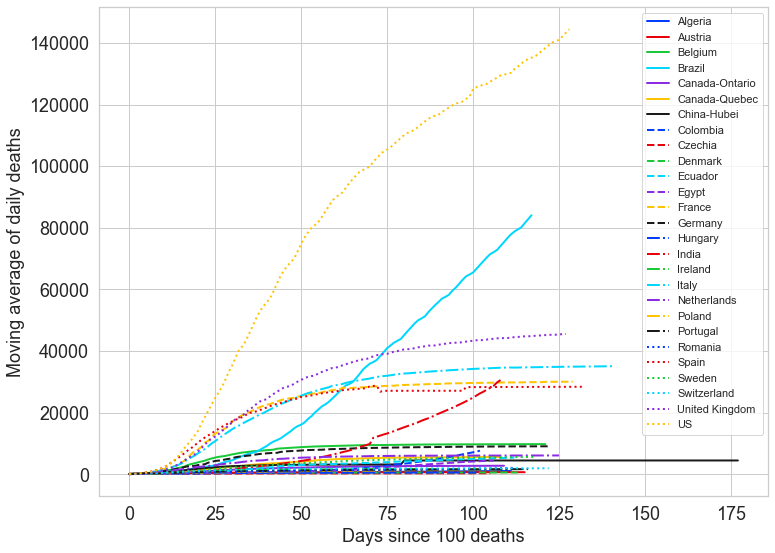

In [7]:

FONTSIZE = 18
fig, ax = plt.subplots()

group = ['Algeria','Austria', 'Belgium', 'Brazil','Canada-Ontario','Canada-Quebec','China-Hubei','Colombia', 'Czechia', 'Denmark','Ecuador','Egypt','France', 'Germany', 'Hungary', 'India', 'Ireland', 'Italy', 'Netherlands', 'Poland', 'Portugal', 'Romania', 'Spain', 'Sweden', 'Switzerland', 'United Kingdom','US']

plt.rcParams['figure.figsize'] = (12.0, 8.0)
#plt.xlim([0,60])
global_deaths_filtered[group].plot(ax = ax,grid=True), plt.legend(), plt.xlabel('Days since 100 deaths', fontsize = FONTSIZE), plt.ylabel('Moving average of daily deaths', fontsize = FONTSIZE)
plt.xticks(fontsize = FONTSIZE), plt.yticks(fontsize = FONTSIZE)


#plt.savefig('../Figures/COVID/aligned_100deaths.pdf', bbox_inches='tight')




In [23]:
trial = filter_data_by_intervention(all_data, google_social)

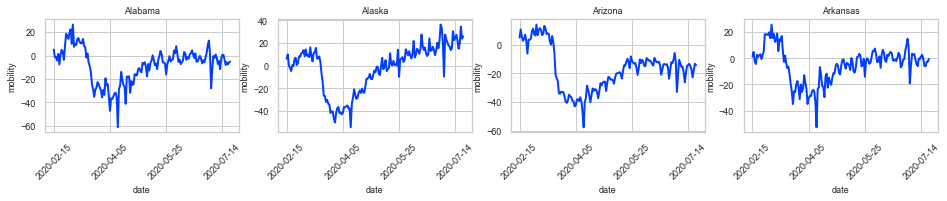

In [25]:
state_list = ['Alabama', 'Alaska', 'Arizona', 'Arkansas']
plt.rcParams['figure.figsize'] = (16,32)

FONTSIZE = 9

#tick_spacing = 30
#ax.xaxis.set_major_locator(ticker.MultipleLocator(tick_spacing))

#plt.setp( ax.get_xticklabels(), visible=False)

mobility_us = mobility_data_google.loc[mobility_data_google.country_region == 
                                       "United States"].pivot_table(index='date', values=mobility_data_google.columns[column], columns='sub_region_1')
#fig, ax = plt.subplots(4)
for i in range(4):


    ax = plt.subplot(13,4, i+1)
    #plt.setp( ax.get_xticklabels(), visible=False)

    #plt.xticks(rotation=45)

    mobility_us[state_list[i]].plot(ax=ax )
    #ax.xaxis.set_major_locator(ticker.MultipleLocator(tick_spacing))
    ax.set_xticklabels(ax.get_xticklabels(),rotation=45)

    #ax.tick_params(axis='x', rotation=45)
    plt.xlabel('date',fontsize = FONTSIZE), plt.ylabel('mobility',fontsize = FONTSIZE), plt.xticks(fontsize = FONTSIZE), plt.yticks(fontsize = FONTSIZE), plt.title(state_list[i], fontsize = FONTSIZE)


    
#plt.savefig('../Figures/COVID/google_mobility.pdf', bbox_inches='tight')

plt.show()

In [27]:
df = deaths_intervention_adjusted_daily
df = df[df.columns[(df>10).any()]].copy()
lambdas=[1,0.01]
df1 = cases_intervention_adjusted_daily[df.columns].iloc[15:,:].copy()

#targets = [ 'New York', 'Illinois', 'Belgium', 'Switzerland', 'New Jersey', 'France', 'Italy', 'United Kingdom']# 'Ohio', 'Sweden']
#targets = newdf.columns
high_thresh = 55
low_thresh = 50
#targets = random.sample(list(deaths_intervention_adjusted_daily.columns),80)
targets = df.columns
sizes = df[targets].apply(pd.Series.last_valid_index)
targets = sizes[sizes>=low_thresh].index


donorpool = sizes[sizes>=high_thresh].index


print(targets)
print(donorpool)
singVals = 3
weight_features = []
move_intervention = 10
for target in targets:
  
    try:
        newdata = synth_control_predictions([df, df1],high_thresh, low_thresh,
                                            "Deaths Data", singVals, ylimit=[], savePlots=False, do_only=[target], showstates=10,
                               exclude=[], svdSpectrum=False, silent=True, showDonors=False, showPlots=False, lambdas=lambdas, mRSC=False, error_thresh = 1)
        weight_features.append(newdata)
    except ValueError:
        print(target)
        continue
feature_list = pd.DataFrame((weight_features))
feature_list.index=targets
feature_list.fillna(0, inplace=True)
#feature_list = feature_list.apply(lambda x: x/x.max(), axis=1)
feature_columns = feature_list.columns
kmeans = KMeans(n_clusters=5)
y = kmeans.fit_predict(feature_list[feature_columns])
feature_list.insert((feature_list.shape[1]),'KMeans',y)
feature_list.groupby('KMeans').groups
clusterer = hdbscan.HDBSCAN(min_cluster_size=2, cluster_selection_method='leaf')
clustering_labels = clusterer.fit_predict(feature_list[feature_columns])
feature_list['DB'] = clustering_labels
feature_list.groupby('DB').groups


Index(['Austria', 'Belgium', 'China-Hubei', 'Czechia', 'Denmark', 'Finland',
       'France', 'Germany', 'Hungary', 'India', 'Ireland', 'Italy',
       'Netherlands', 'Poland', 'Portugal', 'Romania', 'Spain', 'Sweden',
       'Switzerland', 'United Kingdom', 'Alabama', 'Arizona', 'California',
       'Colorado', 'Connecticut', 'Delaware', 'District of Columbia',
       'Florida', 'Georgia', 'Illinois', 'Indiana', 'Iowa', 'Louisiana',
       'Maryland', 'Massachusetts', 'Michigan', 'Minnesota', 'Mississippi',
       'Missouri', 'Nevada', 'New Jersey', 'New Mexico', 'New York',
       'North Carolina', 'Ohio', 'Pennsylvania', 'Rhode Island',
       'South Carolina', 'Tennessee', 'Texas', 'Virginia', 'Washington',
       'Wisconsin', 'King-Washington', 'Los Angeles-California',
       'New York City-New York'],
      dtype='object')
Index(['Austria', 'Belgium', 'China-Hubei', 'Czechia', 'Denmark', 'Finland',
       'France', 'Germany', 'Hungary', 'India', 'Ireland', 'Italy',
       'Nethe

{-1: Index(['Austria', 'Belgium', 'China-Hubei', 'France', 'Germany', 'India',
        'Ireland', 'Italy', 'Netherlands', 'Poland', 'Portugal', 'Spain',
        'Switzerland', 'United Kingdom', 'Connecticut', 'Illinois', 'Indiana',
        'Iowa', 'Louisiana', 'Maryland', 'Massachusetts', 'Michigan',
        'Mississippi', 'Missouri', 'New Jersey', 'New York', 'North Carolina',
        'Ohio', 'Pennsylvania', 'Rhode Island', 'Washington',
        'Los Angeles-California', 'New York City-New York'],
       dtype='object'),
 0: Index(['Sweden', 'California'], dtype='object'),
 1: Index(['Florida', 'Georgia', 'Texas'], dtype='object'),
 2: Index(['Romania', 'Arizona', 'Colorado', 'Minnesota', 'Virginia'], dtype='object'),
 3: Index(['Czechia', 'South Carolina'], dtype='object'),
 4: Index(['Denmark', 'Hungary', 'King-Washington'], dtype='object'),
 5: Index(['Nevada', 'Tennessee', 'Wisconsin'], dtype='object'),
 6: Index(['Alabama', 'New Mexico'], dtype='object'),
 7: Index(['Finland', 'D

(<matplotlib.axes._subplots.AxesSubplot at 0x125463fa0>,
 Text(0.5, 0, 'Days since lockdown'),
 Text(0, 0.5, 'Moving average of daily deaths'))

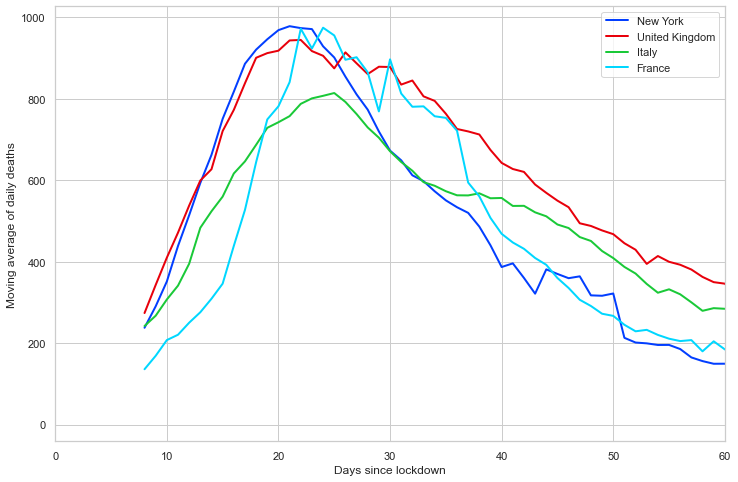

In [32]:
plt.rcParams.update({'font.size': 18})
plt.rcParams['figure.figsize'] = (12, 8)
group = ['New York', 'United Kingdom', 'Italy', 'France']#list(feature_list.groupby('DB').groups[-1])
i = 0
ax = plt.subplot(1,1,1)

df[group].plot(ax = ax, xlim=[0,60]), plt.legend(), plt.xlabel('Days since lockdown'), plt.ylabel('Moving average of daily deaths')

    

(<matplotlib.axes._subplots.AxesSubplot at 0x121187d60>,
 (array([-15.,   0.,  15.,  30.,  45.,  60.,  75.,  90., 105., 120., 135.,
         150., 165.]),
  <a list of 13 Text major ticklabel objects>),
 Text(0.5, 0, 'Chronological Date'),
 Text(0, 0.5, 'Moving average of daily deaths'))

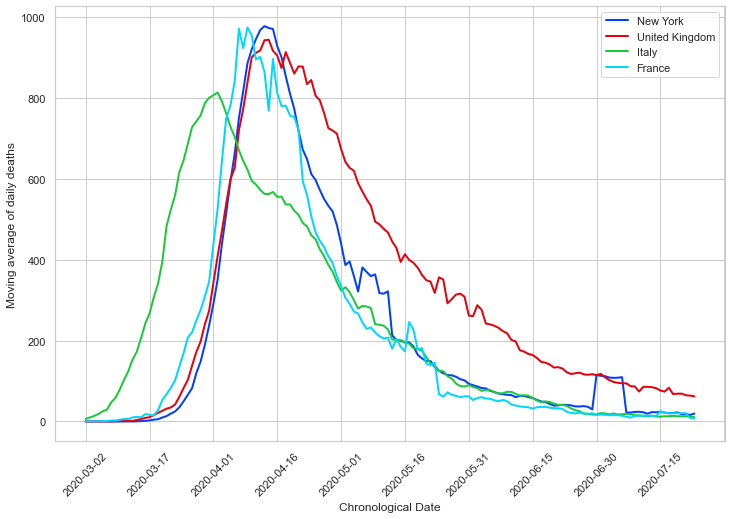

In [36]:
plt.rcParams.update({'font.size': 18})
plt.rcParams['figure.figsize'] = (12, 8)
ax = plt.subplot(1,1,1)
ax.xaxis.set_major_locator(ticker.MultipleLocator(15))
all_data_daily[group].loc['2020-03-02':,:].plot(ax = ax), plt.xticks(rotation=45), plt.legend(), plt.xlabel('Chronological Date'), plt.ylabel('Moving average of daily deaths')


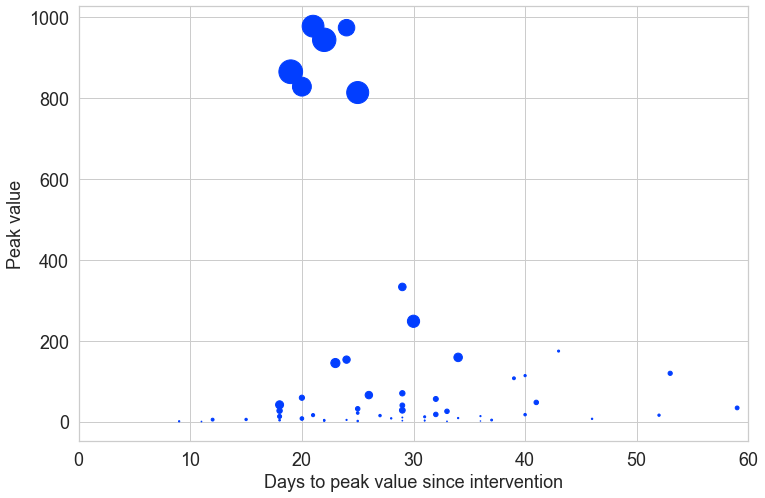

In [37]:
df = create_peak_clusters(deaths_intervention_adjusted_daily,7)
plt.figure(figsize=(12,8))
#fig, ax = plt.subplots(1,1)
FONTSIZE = 18

plt.rcParams.update({'font.size': 20})
tick_spacing = 30
# this is a bug in matplotlib
#plt.rcParams['figure.figsize'] = (24.0, 18.0)

#label_markings = ax.get_xticklabels()
#ax.set_xticklabels(label_markings, rotation=45)
#ax.xaxis.set_major_locator(ticker.MultipleLocator(tick_spacing))
plt.xlim([0,60])
plt.scatter(df['days to peak'], (df['peak value']), s=2*df['initial value']),
#plt.scatter(global_peak_size_thresh['days to peak'], (global_peak_size_thresh['peak value']), s=2*global_peak_size_thresh['initial value'], color='r'), 
plt.xlabel('Days to peak value since intervention',fontsize=FONTSIZE)#, plt.title('Marker Size = Death Count when intervention applied', fontdict = {'fontsize' : FONTSIZE}),
plt.ylabel('Peak value',fontsize=FONTSIZE)
plt.xticks(fontsize=FONTSIZE), plt.yticks(fontsize=FONTSIZE)


variablelabel = df.index

for i, txt in enumerate(variablelabel):
    if(df['peak value'][i]>3500):
        plt.annotate(txt, (df['days to peak'][i], df['peak value'][i]+20))

#plt.savefig('../Figures/COVID/lockdown_impact.pdf', bbox_inches='tight')


In [40]:
country_population = pd.read_excel("../data/mobility/country_pop_WDI.xlsx")
county_population = pd.read_excel("../data/mobility/co-est2019-annres.xlsx", header=[3])
new = county_population['Unnamed: 0'].str.replace(".","").str.replace(" County","").str.split(pat=",", expand=True)
county_population['state']=new[1].str.strip()
state_population = county_population.groupby('state').sum()
us_state_population = pd.DataFrame()
us_state_population['Country'] = state_population.index
us_state_population['Value'] = state_population[[2019]].values

all_population = pd.concat([country_population, us_state_population], axis=0, ignore_index=True)

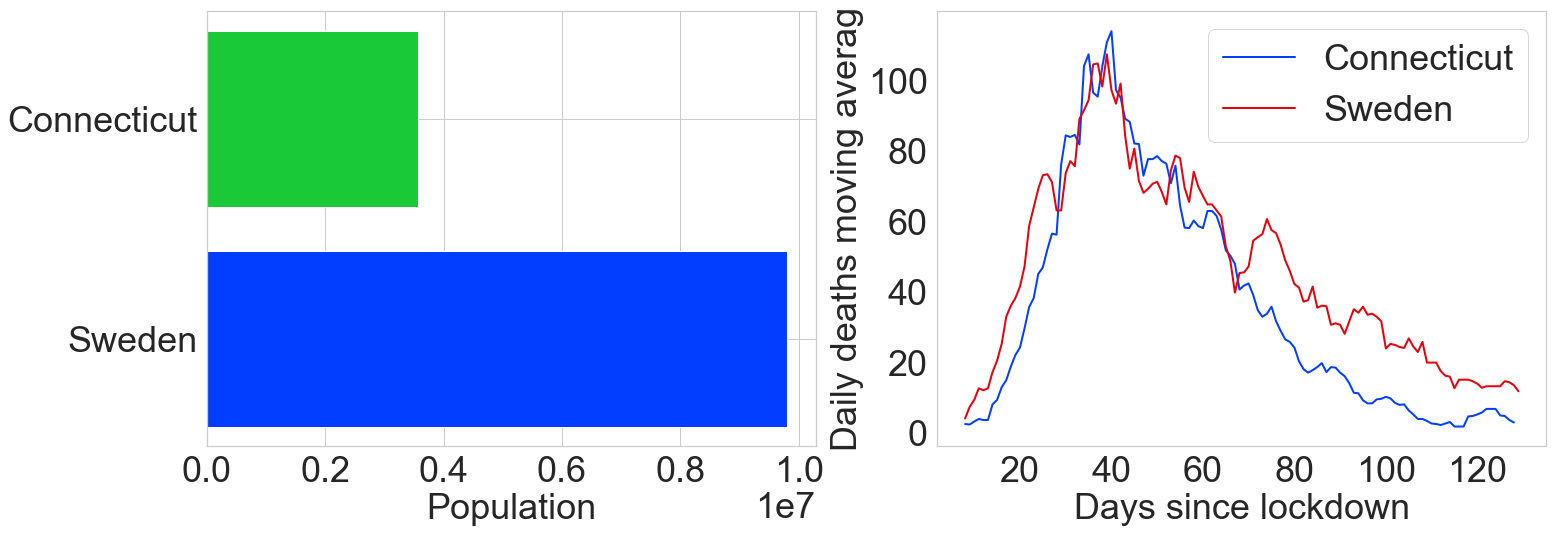

In [41]:
#targets = ['Sweden', 'Denmark', 'Norway', 'Finland']
#targets = ['India', 'Russia', 'Brazil']
#targets = ['Michigan', 'Netherlands']
targets = ['Connecticut', 'Sweden'] #'California', 
FONTSIZE = 36
#targets = ['Austria', 'Czechia', 'Hungary']
plt.rcParams['figure.figsize'] = (24.0, 8.0)
ax = plt.subplot(1,2,2)
deaths_intervention_adjusted_daily[targets].plot(ax = ax), plt.xlabel('Days since lockdown', fontsize = FONTSIZE), plt.ylabel('Daily deaths moving averag', fontsize = FONTSIZE), plt.grid()
plt.xticks(fontsize=FONTSIZE), plt.yticks(fontsize=FONTSIZE), plt.legend(fontsize=FONTSIZE)
#plt.show()
ax = plt.subplot(1,2,1)
plt.barh(all_population[all_population.Country.isin(targets)].Country, all_population[all_population.Country.isin(targets)].Value, 
         color=list('bgrcyk')),plt.xlabel('Population', fontsize = FONTSIZE)
plt.xticks(fontsize=FONTSIZE), plt.yticks(fontsize=FONTSIZE)
ax.xaxis.get_offset_text().set_fontsize(FONTSIZE)


#plt.savefig('../Figures/COVID/cluster1.pdf',bbox_inches='tight')

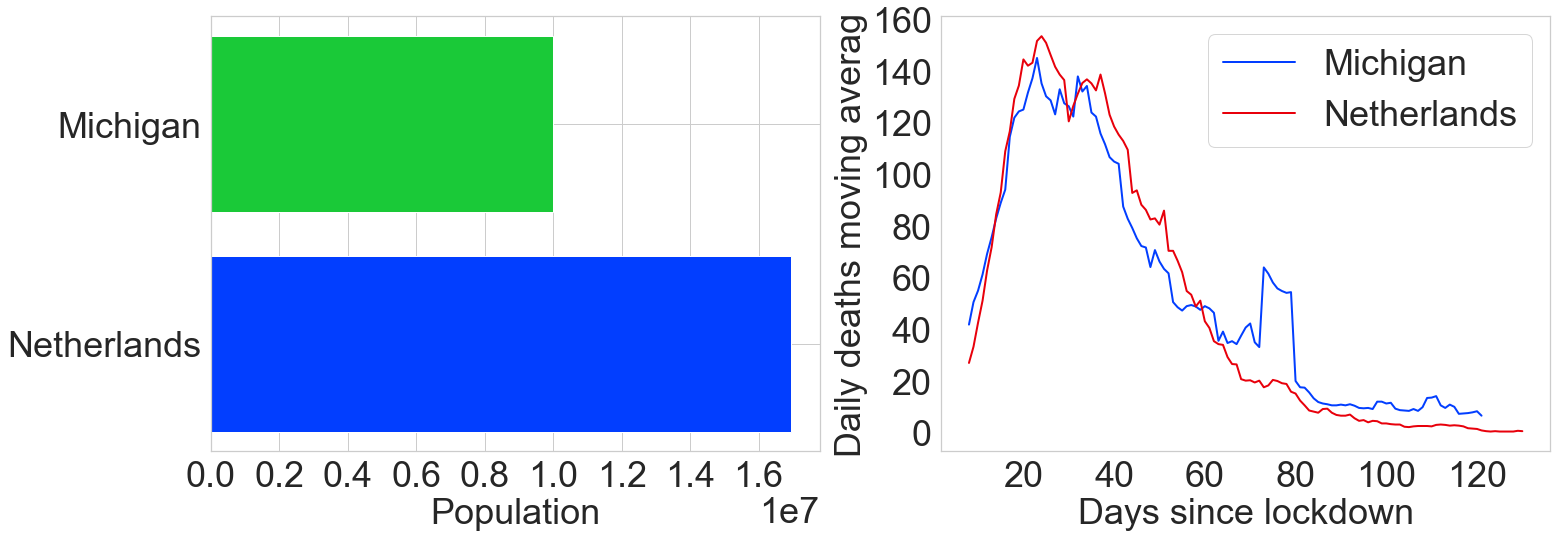

In [42]:
#targets = ['Sweden', 'Denmark', 'Norway', 'Finland']
#targets = ['India', 'Russia', 'Brazil']
targets = ['Michigan', 'Netherlands']
FONTSIZE = 36
#targets = ['Austria', 'Czechia', 'Hungary']
plt.rcParams['figure.figsize'] = (24.0, 8.0)
ax = plt.subplot(1,2,2)
deaths_intervention_adjusted_daily[targets].plot(ax = ax), plt.xlabel('Days since lockdown', fontsize = FONTSIZE), plt.ylabel('Daily deaths moving averag', fontsize = FONTSIZE), plt.grid()
plt.xticks(fontsize=FONTSIZE), plt.yticks(fontsize=FONTSIZE), plt.legend(fontsize=FONTSIZE)
#plt.show()
ax = plt.subplot(1,2,1)
plt.barh(all_population[all_population.Country.isin(targets)].Country, all_population[all_population.Country.isin(targets)].Value, 
         color=list('bgrcyk')),plt.xlabel('Population', fontsize = FONTSIZE)
plt.xticks(fontsize=FONTSIZE), plt.yticks(fontsize=FONTSIZE)
ax.xaxis.get_offset_text().set_fontsize(FONTSIZE)


#plt.savefig('../Figures/COVID/cluster1.pdf',bbox_inches='tight')

In [52]:

df = deaths_intervention_adjusted_daily
df = df[df.columns[(df>10).any()]].copy()

df1 = cases_intervention_adjusted_daily[df.columns].copy()

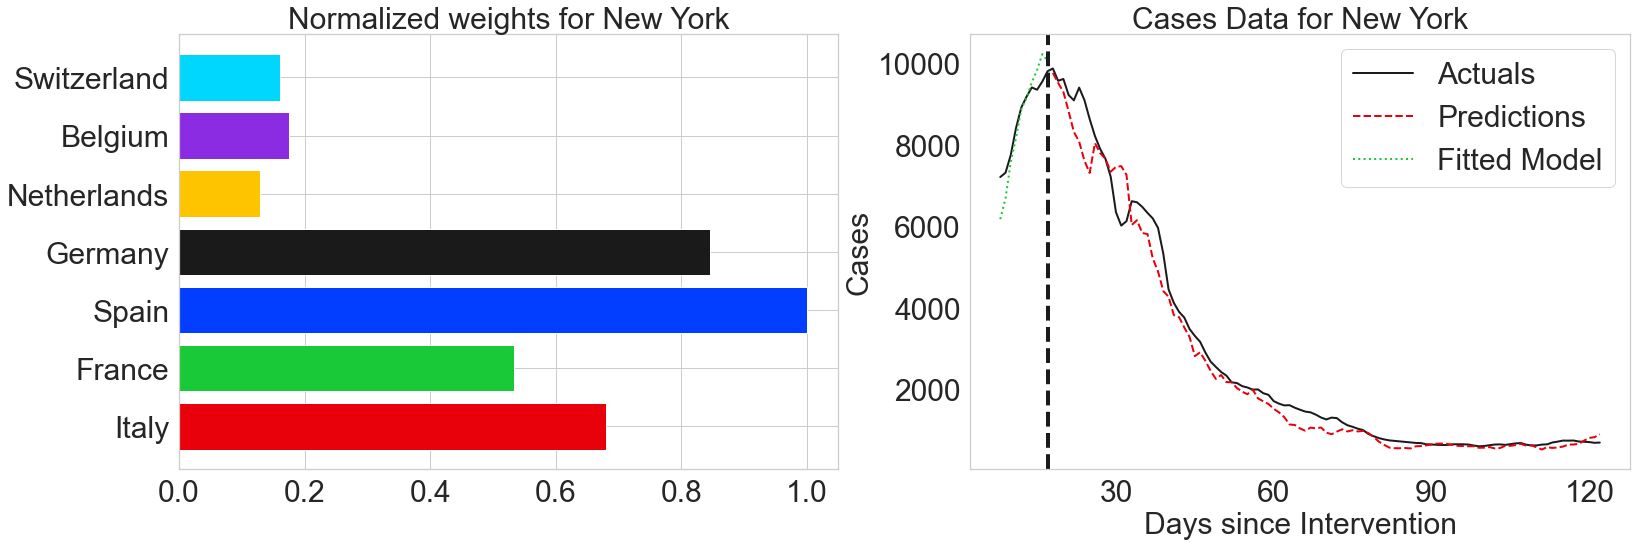

In [54]:
#plt.rcParams['figure.figsize'] = (24.0, 9.0)
#plt.rcParams.update({'font.size': 12})
lambdas = [1, 50]

projection_period=120
training_period=10
fig, axes = plt.subplots(1, 2, figsize=(26,8))
newdata = synth_control_predictions([df1, df],projection_period, training_period, 
                                            "Cases Data", 1, ylimit=[], savePlots=False, do_only=['New York'], showstates=10,
                               exclude=[target], figure=fig, axes=axes, donorPool=['Italy', 'United Kingdom', 'France', 'Spain', 'Germany', 'Netherlands', 'Belgium', 'Switzerland'], 
                                    svdSpectrum=False, silent=True, showDonors=True, showPlots=True, lambdas=lambdas, mRSC=False, error_thresh = 10, FONTSIZE=30)



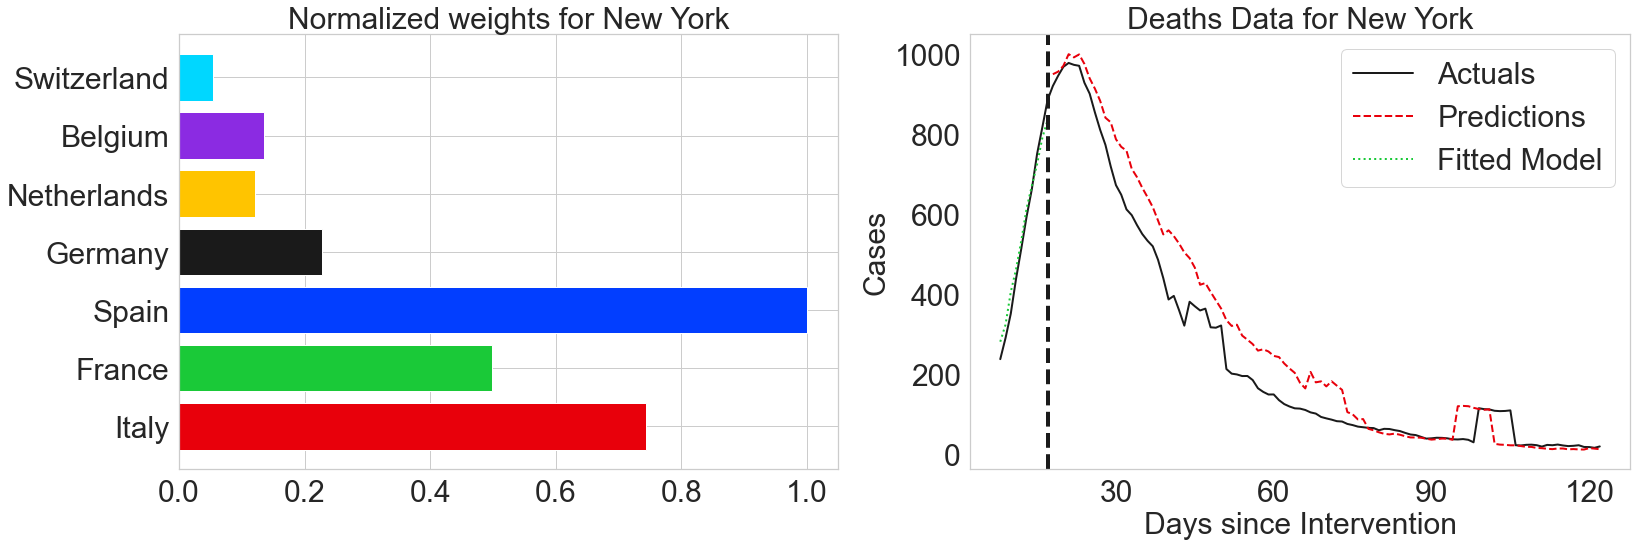

In [53]:
#plt.rcParams['figure.figsize'] = (24.0, 9.0)

lambdas = [1, 0.02]
projection_period=120
training_period=10
fig, axes = plt.subplots(1, 2, figsize=(26,8))
newdata = synth_control_predictions([df, df1],projection_period, training_period,
                                            "Deaths Data", 1, ylimit=[], savePlots=False, do_only=['New York'], showstates=10,
                               exclude=[target], figure=fig, axes=axes, donorPool=['Italy', 'United Kingdom', 'France', 'Spain', 'Germany', 'Netherlands', 'Belgium', 'Switzerland'],
                                    svdSpectrum=False, silent=True, showDonors=True, showPlots=True, lambdas=lambdas, mRSC=False, error_thresh = 10, FONTSIZE=30)





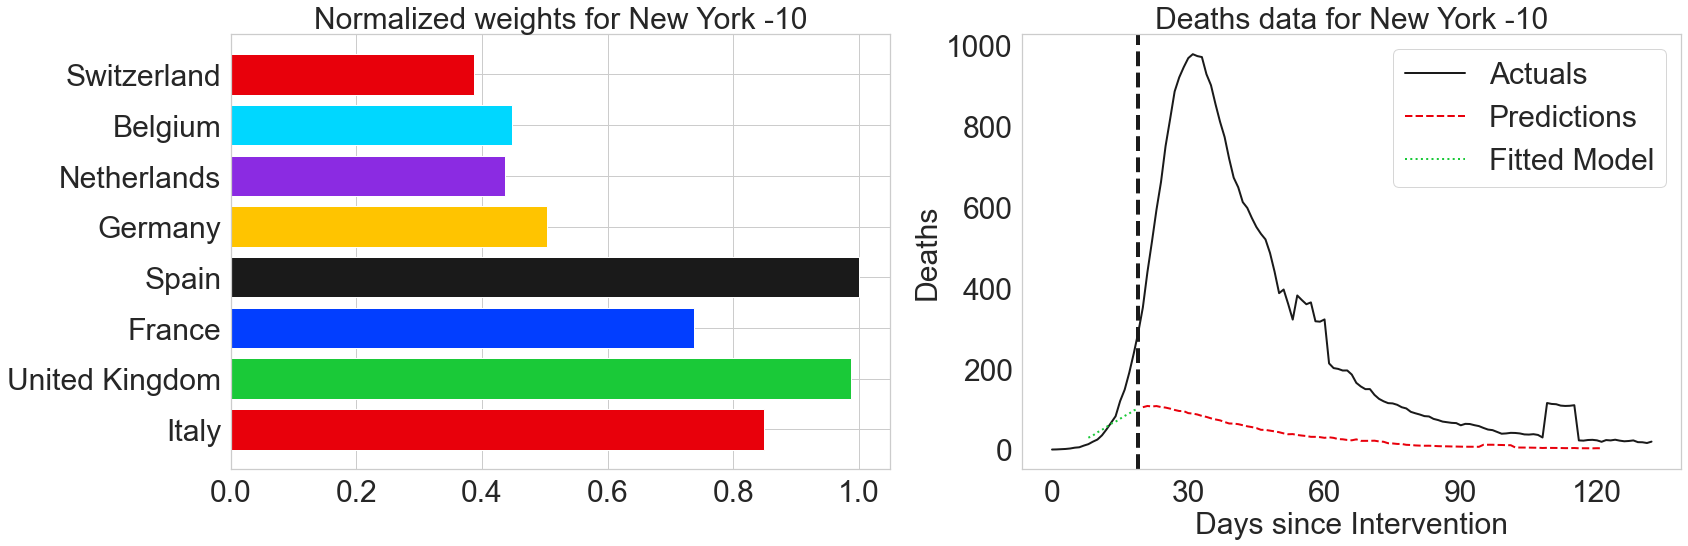

In [47]:
singVals = 1
projection_period=130
training_period=20

fig, axes = plt.subplots(1, 2, figsize=(26,8))
temp_df,_= filter_data_by_intervention(all_data_daily[['New York']], educational_distancing, 10)

# This has been made silent as to not flood the output
#[pd.concat([deaths_intervention_adjusted_daily,temp_df]
return_value = synth_control_predictions([pd.concat([deaths_intervention_adjusted_daily,temp_df], axis=1)], projection_period, training_period, "Deaths data", singVals, ylimit=[], 
                           savePlots=False, do_only=["New York -10"], showstates=10,
                           exclude=['New York'], figure=fig, axes=axes, donorPool=['Italy', 'United Kingdom', 'France', 'Spain', 'Germany', 'Netherlands', 'Belgium', 'Switzerland'], 
                           svdSpectrum=False, silent=True, showDonors=True, showPlots=True,  mRSC=False, error_thresh = 10, FONTSIZE=30, yaxis = 'Deaths')#lambdas=lambdas, random_distribution=dist



((array([-30.,   0.,  30.,  60.,  90., 120., 150., 180., 210.]),
  <a list of 9 Text major ticklabel objects>),
 (array([-10000.,      0.,  10000.,  20000.,  30000.,  40000.,  50000.,
          60000.,  70000.,  80000.]),
  <a list of 10 Text major ticklabel objects>))

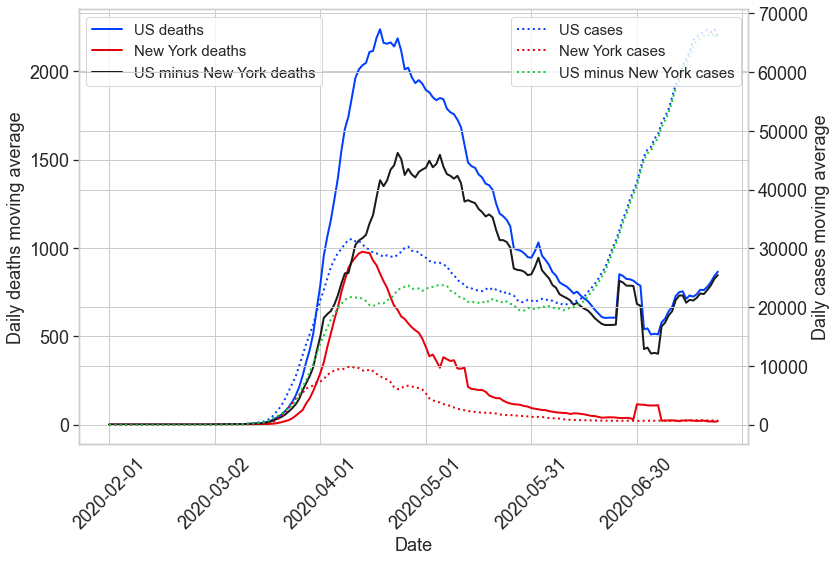

In [57]:
FONTSIZE = 18

fig, ax1 = plt.subplots()
ax1.set_xlabel('date')
ax1.set_ylabel('daily deaths moving average')



tick_spacing = 30
# this is a bug in matplotlib
plt.rcParams['figure.figsize'] = (12.0, 8.0)
plt.rcParams.update({'font.size': FONTSIZE})
label_markings = ax.get_xticklabels()
ax1.set_xticklabels(label_markings, rotation=45)
ax1.xaxis.set_major_locator(ticker.MultipleLocator(tick_spacing))

tri_state = all_data_daily['New York']#+all_data_daily['New Jersey']+all_data_daily['Connecticut']
tri_state_cases = all_data_cases_daily['New York']#+all_data_daily['New Jersey']+all_data_daily['Connecticut']

us_minus_new_york = all_data_daily['US'] - tri_state
us_minus_new_york_cases = all_data_cases_daily['US'] - tri_state_cases

all_data_daily['US'].loc['2020-02-01':].plot(ax=ax1, label='US deaths'), tri_state.loc['2020-02-01':].plot(ax=ax1, label="New York deaths"), 
us_minus_new_york.loc['2020-02-01':].plot(ax=ax1,color='k', label="US minus New York deaths"), plt.ylabel('Daily deaths moving average', fontsize = FONTSIZE ), plt.xlabel('Date',fontsize = FONTSIZE)
plt.legend(fontsize = 15, loc='upper left')
plt.xticks(fontsize = FONTSIZE), plt.yticks(fontsize = FONTSIZE)
plt.xticks(rotation=45)

ax2 = ax1.twinx()
all_data_cases_daily['US'].loc['2020-02-01':].plot(ax=ax2, label='US cases', secondary_y=True,linestyle=":"), 
tri_state_cases.loc['2020-02-01':].plot(ax=ax2, label="New York cases", secondary_y=True,linestyle=":"),  
us_minus_new_york_cases.loc['2020-02-01':].plot(ax=ax2, label="US minus New York cases", secondary_y=True,linestyle=":"), plt.ylabel('Daily cases moving average', fontsize = FONTSIZE)
plt.setp( ax.get_xticklabels(), visible=True), plt.legend(fontsize = 15, loc='upper right')
plt.xticks(fontsize = FONTSIZE), plt.yticks(fontsize = FONTSIZE)

#plt.savefig('../Figures/COVID/US_vs_NY.pdf', bbox_inches='tight')
